In [4]:
import os
os.chdir('/Users/ngdnhtien/Research/Codespace/bosonic/bqec@huikhoon')

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import utility as ut
import constant as constant
import math
from scipy.optimize import minimize

%config InlineBackend.figure_formats = ['svg']

# One-mode case

In [5]:
dim_a = 20
dim_c = 10

a = qt.tensor(qt.destroy(dim_a), qt.qeye(dim_c))
c = qt.tensor(qt.qeye(dim_a), qt.destroy(dim_c))

n_a = a.dag() * a
n_c = c.dag() * c

# Lab frame

In [6]:
omega_10 = 4.936 # GHz
alpha = 0.168 # GHz

r1 = 9.64
r2 = 0.26
r3 = 0
r4 = 0.064

delta_a = r1 * alpha
omega_a = omega_10 + delta_a
omega_c = omega_10 + alpha

delta_d = r2 * alpha
omega_d = omega_10 + delta_d

Omega_d = 1j * r3 * delta_d

g_a = r4 * delta_a 

H_cav = omega_a * n_a 

EC = alpha
EJ = omega_c**2 / (8 * alpha)
n_charge = -1j * (8 * EC / EJ)**(-1/4) * (c - c.dag()) / np.sqrt(2)
sc_phase = (8 * EC / EJ)**(1/4) * (c + c.dag()) / np.sqrt(2) 
H_anc = 4 * EC * n_charge**2 - EJ * sc_phase.cosm()
H_int = 1j * np.real(g_a) * (c - c.dag()) * (a.dag() + a)

H0 = H_cav + H_anc + H_int

def H1_coeff(t, args):
    return np.exp(1j * omega_d * t)

H1 = (c - c.dag()) * (np.conj(Omega_d))

def H2_coeff(t, args):
    return np.exp(-1j * omega_d * t)

H2 = - (c - c.dag()) * Omega_d

## Without drive

In [60]:
K2 = 2.63 * 1e-6
K3 = 1e-7
H = omega_a * a.dag() * a + K2 * a.dag() * a.dag() * a * a + K3 * a.dag() * a.dag() * a.dag() * a * a * a

In [61]:
time_10us = np.linspace(0, 2*np.pi*10000, 50)
init_state = qt.tensor(qt.coherent(dim_a, 1.5), qt.fock(dim_c, 0))

In [62]:
res = qt.mesolve(H=H, rho0=init_state, tlist=time_10us, c_ops=None, e_ops=None,
                options={'progress_bar':'text', 'nsteps':500000})

qt.qsave(res, 'cross_Kerr/data/1mode_10us_sim')

10.2%. Run time:  12.99s. Est. time left: 00:00:01:54
20.4%. Run time:  25.90s. Est. time left: 00:00:01:41
30.6%. Run time:  38.85s. Est. time left: 00:00:01:28
40.8%. Run time:  51.77s. Est. time left: 00:00:01:15
51.0%. Run time:  64.69s. Est. time left: 00:00:01:02
61.2%. Run time:  77.61s. Est. time left: 00:00:00:49
71.4%. Run time:  90.53s. Est. time left: 00:00:00:36
81.6%. Run time: 103.44s. Est. time left: 00:00:00:23
91.8%. Run time: 116.38s. Est. time left: 00:00:00:10
100.0%. Run time: 126.72s. Est. time left: 00:00:00:00
Total run time: 126.72s


In [63]:
res = qt.qload('cross_Kerr/data/1mode_10us_sim')

# Effective Hamiltonian (lab frame)

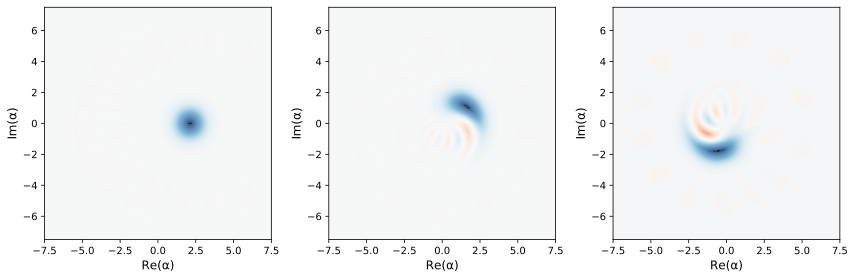

In [65]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12,4))
qt.plot_wigner(init_state.ptrace(0), ax=ax1, fig=fig)
qt.plot_wigner(res.states[30].ptrace(0), ax=ax2, fig=fig)
qt.plot_wigner(res.states[-1].ptrace(0), ax=ax3, fig=fig)
fig.tight_layout()

In [69]:
def H_eff(K, beta):
    return (omega_a) * a.dag() * a + (K) * a.dag() * a.dag() * a * a + (beta) * a.dag() * a.dag() * a.dag() * a * a * a

In [68]:
full_sim_states = res.states

In [83]:
def objective(args):

    K, beta = args
    H = H_eff(K, beta)

    infd_list = []

    for idx, t in enumerate(time_10us):
        evol_state = ((-1j*H*t).expm() * init_state).unit()
        infd = np.abs(1 - qt.fidelity(evol_state.ptrace(0), full_sim_states[idx].ptrace(0)))
        infd_list.append(infd)
        
    print(np.average(infd_list))
    return np.average(infd_list)

In [84]:
x0 = [2.63 * 1e-6, 1e-7]

In [88]:
solution = minimize(objective, x0, method='Nelder-Mead', tol=1e-7)

0.005530873316823597
0.004704988445818359
0.005347806955109118
0.004607364956810429
0.004502555648882212
0.004925858254315494
0.004596882046011914
0.004893206422838619
0.004560001453684129
0.004581415181665307
0.004536595798734959
0.00446543882689731
0.004430987522672451
0.0044943996828043994
0.004435212523653227
0.0043634436277106906
0.004326949298549785
0.004463185302432995
0.004387638254418216
0.004273154533177879
0.004201603682322872
0.004169490633219248
0.004117199271093716
0.0039820911075534714
0.0038664737247254013
0.003971348335219818
0.0038268635892476466
0.003916069404914688
0.0037232953354283315
0.0037137699363985655
0.0037477851238556935
0.003872189364685226
0.0037212227684789625
0.003800081407716078
0.003700500879943287
0.003741901639362266
0.003695514583393771
0.0037863624832621067
0.003691282990242761
0.0037054557190378114
0.003692611971971922
0.003692431753711829
0.003707678115335027
0.0036896957685392585
0.003691818207816968
0.003690283271632857
0.0036915295111671466
0

In [89]:
solution

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0036896671510937853
             x: [ 2.335e-06  2.639e-07]
           nit: 29
          nfev: 53
 final_simplex: (array([[ 2.335e-06,  2.639e-07],
                       [ 2.339e-06,  2.635e-07],
                       [ 2.329e-06,  2.658e-07]]), array([ 3.690e-03,  3.690e-03,  3.690e-03]))